# Fake Face Detection
## Background
Recently, generative AI's capability is rapidly increasing. And many researchers in A.I. field are warning against current situation.  
Now we can generate what is called deepfake movies easily. For example, we can generate fully synthesized movie of president speech.  

Now there is an increasing demand to differentiate fake and real.  
Here, I'll implement detection algorithm using kaggle dataset called [Real vs Fake Faces - 10k](https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k/data).

In this dataset, both real human face and A.I. generated face are included. We are requested to differentiate them.  
I chose this dataset because recent significant update made differenciation more difficult, and lots of concerns are raised.

Image size is 256x256, and only head shot images are included.

### Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
import matplotlib.pyplot as plt

import os
import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_df = pd.read_csv("train.csv")
valid_df = pd.read_csv("valid.csv")

In [3]:
train_df.head()

Unnamed: 0                                      original_path     id  \
0        1052  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  28609   
1       13406  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  30395   
2       16376  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  22430   
3       31373  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  58380   
4       21034  /kaggle/input/flickrfaceshq-dataset-nvidia-par...  62044   

   label label_str                  path  
0      1      real  train/real/28609.jpg  
1      1      real  train/real/30395.jpg  
2      1      real  train/real/22430.jpg  
3      1      real  train/real/58380.jpg  
4      1      real  train/real/62044.jpg

### Replace path
file path modified for simplification

In [4]:
def replace_dirname(path):
    return os.path.join("./rvf10k/", path)

train_df["path"] = train_df["path"].apply(replace_dirname)
valid_df["path"]= valid_df["path"].apply(replace_dirname)

***
## EDA
### Let's visualize
Below is example visualization for randomly chosen images. It seems quite difficult to tell from first look...

In [5]:
def visualize_face_image(n):
    idces = random.sample(range(train_df.shape[0]), n)
    n_column = 5
    n_row = n // 5

    fig, axes = plt.subplots(n_row, n_column, figsize=(20,16), dpi=160)
    axes = axes.ravel()

    for i, idx in enumerate(idces):
        img = cv2.imread(train_df["path"].iloc[idx])
        b,g,r = cv2.split(img)
        img = cv2.merge([r,g,b])
        axes[i].imshow(img, interpolation='nearest')
        axes[i].set_title(str(train_df["id"].iloc[idx]) + ": " + train_df["label_str"].iloc[idx])
    plt.show()

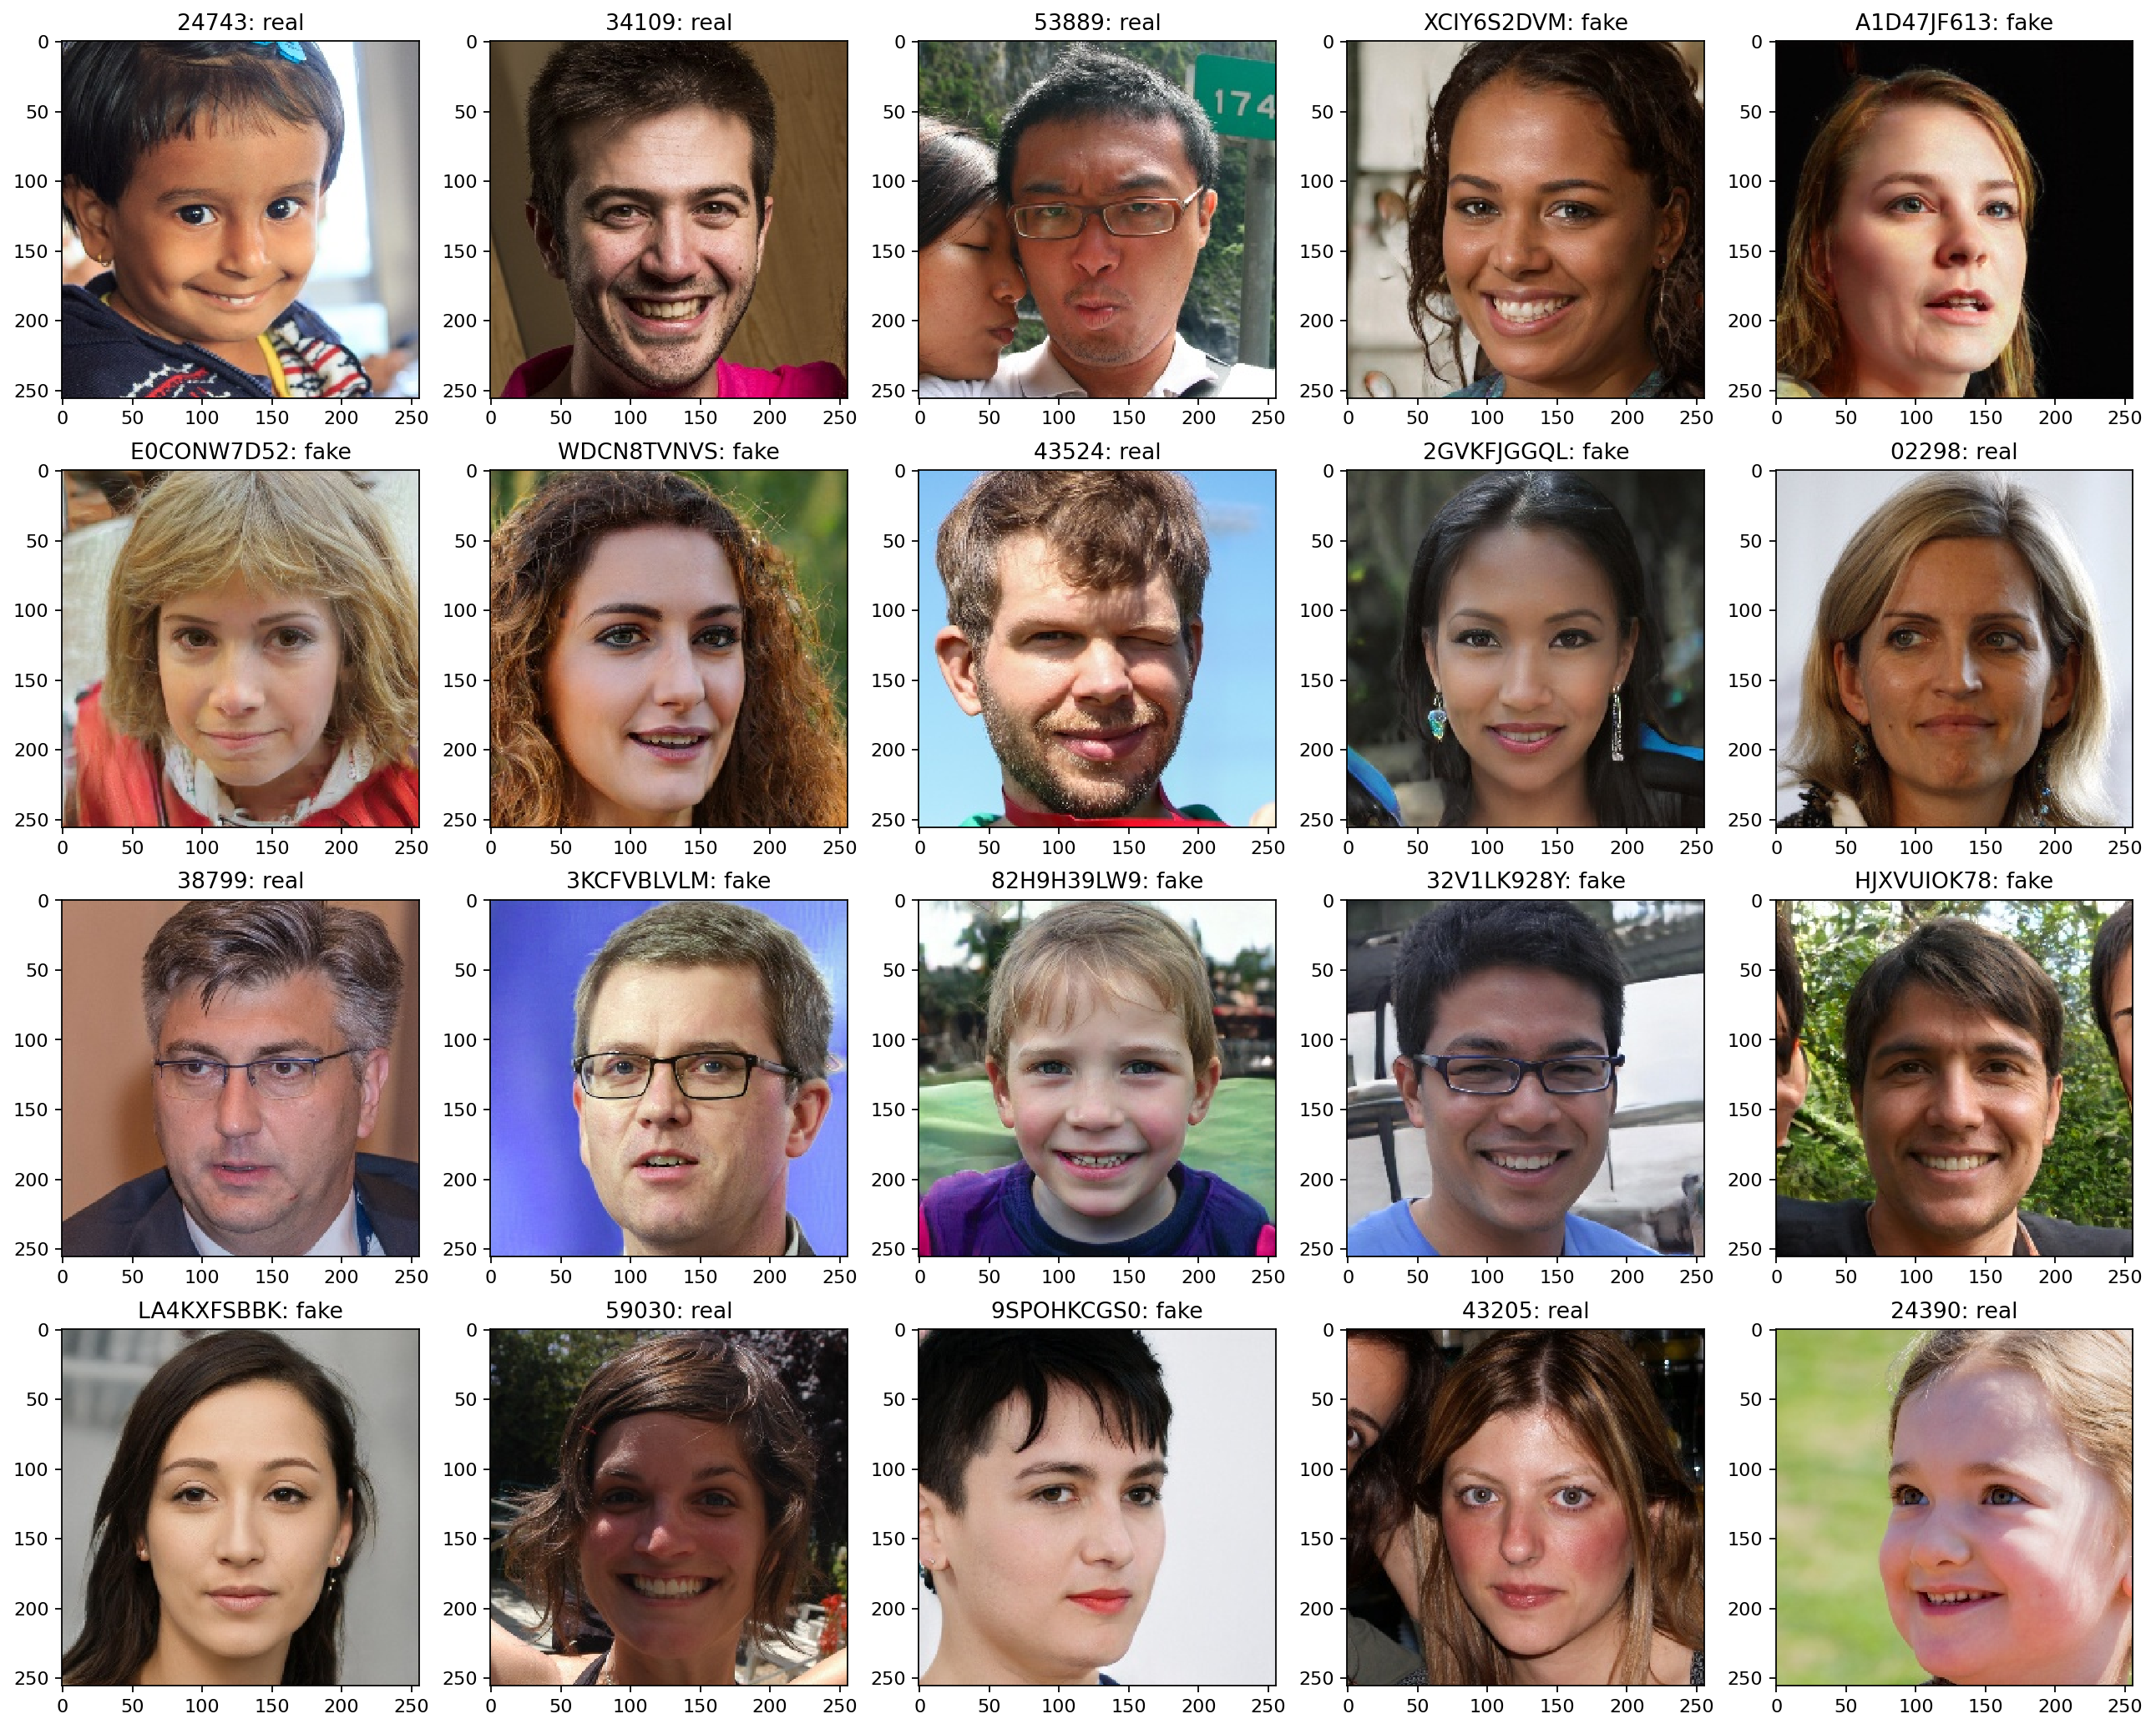

In [6]:
visualize_face_image(20)

### Data Biases
Number of the positive/negative samples are the same. We don't need to care so much about bias from imbalanced dataset.  
At the same time, we can say that random guess leads to 50% accuracy.

In [7]:
print("-- training set --")
print(train_df["label_str"].value_counts())
print(" ")
print("-- validation set --")
print(valid_df["label_str"].value_counts())

-- training set --
label_str
real    3500
fake    3500
Name: count, dtype: int64
 
-- validation set --
label_str
real    1500
fake    1500
Name: count, dtype: int64


In [ ]:
# Randomly select n indices from the dataframe
n = train_df.shape[0]

# Allocate a numpy array
X = np.zeros([n, 256, 256, 3], dtype=np.uint8)
y = np.squeeze(df['label'].values)

# read images
for i, idx in range(n):
    X[i] = cv2.imread(df.loc[i, 'path'])

In [ ]:
# seperate positive and negaive sample and get means
pos_samples = X[y == 1]
neg_samples = X[y == 0]

n_smaller= min(len(pos_samples), len(neg_samples))
if len(pos_samples) > len(neg_samples):
    pos_samples = pos_samples[0: n_smaller]
else:
    neg_samples = neg_samples[0: n_smaller]

# means brightness of positive and negative samples
pos_sample_avgs=np.mean(pos_samples, axis=(1,2,3))
neg_sample_avgs=np.mean(neg_samples, axis=(1,2,3))
pos_sample_mins=np.min(pos_samples, axis=(1,2,3))
neg_sample_mins=np.min(neg_samples, axis=(1,2,3))
pos_sample_maxs=np.max(pos_samples, axis=(1,2,3))
neg_sample_maxs=np.max(neg_samples, axis=(1,2,3))

In [ ]:
# Plot mean,min,max brightness histograms for positive and negative samples
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].hist(pos_sample_avgs, bins= 60, alpha=0.5, label="positive")
axs[0].hist(neg_sample_avgs, bins= 60, alpha=0.5, label="negative")
axs[0].set_title("Mean brightness histogram")
axs[0].set_xlabel("Mean pixel value", size=14)
axs[0].set_ylabel("Count", size=14)
axs[0].set_xlim([0, 255])
axs[0].legend(loc='upper right')

axs[1].hist(pos_sample_mins, bins= 60, alpha=0.5, label="positive")
axs[1].hist(neg_sample_mins, bins= 60, alpha=0.5, label="negative")
axs[1].set_title("Min brightness histogram")
axs[1].set_xlabel("Min pixel value", size=14)
axs[1].set_ylabel("Count", size=14)
axs[1].set_xlim([0, 255])
axs[1].legend(loc='upper right')

axs[2].hist(pos_sample_maxs, bins= 60, alpha=0.5, label="positive")
axs[2].hist(neg_sample_maxs, bins= 60, alpha=0.5, label="negative")
axs[2].set_title("Max brightness histogram")
axs[2].set_xlabel("Max pixel value", size=14)
axs[2].set_ylabel("Count", size=14)
axs[2].set_xlim([0, 255])
axs[2].legend(loc='upper right')


### Prepare Generator
Directory structure of this dataset is suitable for utilizing ImageDataGenerator.  

In [8]:
img_size = 256
batch_size = 64

img_gen = ImageDataGenerator(rescale  = 1./255,
                             zoom_range = .1,
                             horizontal_flip=True,
                             brightness_range= (0.8,1.2),
                             validation_split = .1)

test_gen = ImageDataGenerator(rescale  = 1./255) #preparation through evaluation

#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
mymodel_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)
train_dataset = img_gen.flow_from_directory(
    'rvf10k/train',
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset="training",

)
val_dataset = img_gen.flow_from_directory(
    'rvf10k/train',
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    subset="validation",
)

test_dataset = test_gen.flow_from_directory(
    'rvf10k/valid',
    target_size=(img_size, img_size),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    #subset=None,
)

Found 6300 images belonging to 2 classes.
Found 700 images belonging to 2 classes.
Found 3001 images belonging to 2 classes.


***
## Define Model
Below is my base model. Relatively simple model is used for initial trial.

Accuracy, AUC, Loss are plotted for visual comparison. We can see that this model achieves around 77% accuracy at highest.  
But at the same time, model starts to show overfitting treand around 7 or 8 epochs.

Training accuracy is still stably increasing. So I decided to try transfer learning to see if we can build a better model.

In [9]:
base_model = tf.keras.models.Sequential([
   tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
   tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
   tf.keras.layers.MaxPooling2D((2, 2)),
   tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
   tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
   tf.keras.layers.MaxPooling2D((2, 2)),
   tf.keras.layers.Conv2D(64, (1, 1), activation='relu', padding='same'),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dense(64, activation='relu'),
   tf.keras.layers.Dense(2, activation='softmax')
])

# Model summary
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

In [10]:
# compile model 1

# Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000 # total steps = (training size/batchsize) * number of epochs, 200,000/64*3= around 10000
decay_rate = 0.9
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= lr_schedule),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)

In [11]:
# Fit model 1

base_model.fit(train_dataset, validation_data=val_dataset, epochs=15, batch_size=64, verbose=2)

Epoch 1/15
99/99 - 80s - loss: 0.7230 - categorical_accuracy: 0.5362 - auc: 0.5485 - val_loss: 0.6910 - val_categorical_accuracy: 0.5486 - val_auc: 0.5668 - 80s/epoch - 811ms/step
Epoch 2/15
99/99 - 75s - loss: 0.6698 - categorical_accuracy: 0.6040 - auc: 0.6335 - val_loss: 0.6492 - val_categorical_accuracy: 0.6343 - val_auc: 0.6710 - 75s/epoch - 759ms/step
Epoch 3/15
99/99 - 75s - loss: 0.6419 - categorical_accuracy: 0.6386 - auc: 0.6866 - val_loss: 0.6333 - val_categorical_accuracy: 0.6429 - val_auc: 0.6910 - 75s/epoch - 759ms/step
Epoch 4/15
99/99 - 76s - loss: 0.6269 - categorical_accuracy: 0.6484 - auc: 0.7067 - val_loss: 0.6547 - val_categorical_accuracy: 0.6171 - val_auc: 0.6621 - 76s/epoch - 768ms/step
Epoch 5/15
99/99 - 76s - loss: 0.6187 - categorical_accuracy: 0.6656 - auc: 0.7189 - val_loss: 0.6131 - val_categorical_accuracy: 0.6486 - val_auc: 0.7226 - 76s/epoch - 767ms/step
Epoch 6/15
99/99 - 76s - loss: 0.5959 - categorical_accuracy: 0.6846 - auc: 0.7477 - val_loss: 0.609

In [20]:
basemodel_history_acc=     [0.5362, 0.6040, 0.6386, 0.6484, 0.6656, 0.6846, 0.7108, 0.7430, 0.7484, 0.7617, 0.7871, 0.8019, 0.8148, 0.8203, 0.8357]
basemodel_history_acc_val= [0.5486, 0.6343, 0.6429, 0.6171, 0.6486, 0.6714, 0.7243, 0.7143, 0.6757, 0.7500, 0.7543, 0.7386, 0.7671, 0.7629, 0.7314]

basemodel_history_auc=     [0.5485, 0.6335, 0.6866, 0.7067, 0.7189, 0.7477, 0.7837, 0.8144, 0.8270, 0.8399, 0.8654, 0.8796, 0.8925, 0.9007, 0.9110]
basemodel_history_auc_val= [0.5668, 0.6710, 0.6910, 0.6621, 0.7226, 0.7295, 0.7909, 0.7985, 0.7455, 0.8202, 0.8298, 0.8262, 0.8382, 0.8420, 0.8187]

basemodel_history_loss=         [0.7230, 0.6698, 0.6419, 0.6269, 0.6187, 0.5959, 0.5619, 0.5281, 0.5128, 0.4956, 0.4604, 0.4367, 0.4154, 0.3984, 0.3795]
basemodel_history_loss_val=     [0.6910, 0.6492, 0.6333, 0.6547, 0.6131, 0.6092, 0.5540, 0.5443, 0.6087, 0.5188, 0.5141, 0.5158, 0.5100, 0.4968, 0.5343]

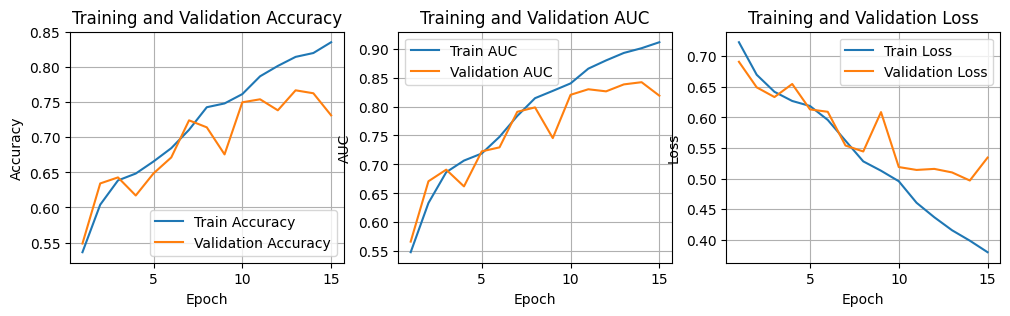

In [24]:
# Plot training and validation AUC
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1, 16),basemodel_history_acc, label='Train Accuracy')
plt.plot(range(1, 16),basemodel_history_acc_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(range(1, 16),basemodel_history_auc, label='Train AUC')
plt.plot(range(1, 16),basemodel_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 3, 3)
plt.plot(range(1, 16),basemodel_history_loss, label='Train Loss')
plt.plot(range(1, 16),basemodel_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

***
## Improvement with Transfer Learning

Here, I used VGG16 as the transfer learning base model. This task is a bit different from the original Imagenet task, so I decided to allow training last 8 layers so that the original NW can adapt to our task. In addition to this, several layers are added for further optimization.

In [14]:
 # Load the VGG16
densenet_model = tf.keras.applications.VGG16(weights='imagenet',include_top = False, input_shape=(256, 256, 3))

# Freeze the weights of the layers.
for layer in densenet_model.layers[:-8]:
    layer.trainable = False

# get the last_layer of inception we want to use
last_layer = densenet_model.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)

base_model = tf.keras.Model(inputs=densenet_model.input, outputs=last_layer.output)
base_model.summary()

last layer output shape:  (None, 16, 16, 512)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (M

In [15]:
# Add layers to the model
mymodel_vgg = tf.keras.models.Sequential([
    base_model,

    tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'), # keep the width and height
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (1, 1),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(2, activation='softmax')
])

# Print the model summary
mymodel_vgg.build(input_shape=(None, 256, 256, 3))
mymodel_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 16, 16, 512)       7635264   
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        73744     
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 16)        272       
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 16)       64        
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)       

### Training and Result
Below are the graph for the new model. Same as base model, I plotted accuracy, AUC and loss.

It seems that the model achieved around 87% validation accuracy! This is a huge improvement. But at the same time, we can see quite unstable result.

In [16]:
#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
mymodel_vgg.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)

In [17]:
BATCH_SIZE = 64
EPOCHS = 15

# data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
)

# Fit vgg model
vgg_history = mymodel_vgg.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/15
99/99 - 90s - loss: 0.6968 - categorical_accuracy: 0.6225 - auc_1: 0.6636 - val_loss: 1.3002 - val_categorical_accuracy: 0.5671 - val_auc_1: 0.6074 - 90s/epoch - 911ms/step
Epoch 2/15
99/99 - 77s - loss: 0.5713 - categorical_accuracy: 0.7125 - auc_1: 0.7747 - val_loss: 0.6104 - val_categorical_accuracy: 0.6529 - val_auc_1: 0.7204 - 77s/epoch - 775ms/step
Epoch 3/15
99/99 - 77s - loss: 0.4989 - categorical_accuracy: 0.7590 - auc_1: 0.8387 - val_loss: 1.0198 - val_categorical_accuracy: 0.5086 - val_auc_1: 0.5696 - 77s/epoch - 775ms/step
Epoch 4/15
99/99 - 77s - loss: 0.4500 - categorical_accuracy: 0.7916 - auc_1: 0.8712 - val_loss: 0.8170 - val_categorical_accuracy: 0.5914 - val_auc_1: 0.7196 - 77s/epoch - 779ms/step
Epoch 5/15
99/99 - 77s - loss: 0.4028 - categorical_accuracy: 0.8152 - auc_1: 0.8982 - val_loss: 0.5487 - val_categorical_accuracy: 0.7471 - val_auc_1: 0.8417 - 77s/epoch - 776ms/step
Epoch 6/15
99/99 - 77s - loss: 0.3511 - categorical_accuracy: 0.8471 - auc_1: 0.

In [27]:
vggmodel_history_acc=     [0.5362, 0.6040, 0.6386, 0.6484, 0.6656, 0.6846, 0.7108, 0.7430, 0.7484, 0.7617, 0.7871, 0.8019, 0.8148, 0.8203, 0.8357]
vggmodel_history_acc_val= [0.5671, 0.6529, 0.5086, 0.5914, 0.7471, 0.7414, 0.8143, 0.5700, 0.8757, 0.6643, 0.7900, 0.8757, 0.7457, 0.5914, 0.7986]

vggmodel_history_auc=     [0.5485, 0.6335, 0.6866, 0.7067, 0.7189, 0.7477, 0.7837, 0.8144, 0.8270, 0.8399, 0.8654, 0.8796, 0.8925, 0.9007, 0.9110]
vggmodel_history_auc_val= [0.6074, 0.7204, 0.5696, 0.7196, 0.8417, 0.8288, 0.8861, 0.5773, 0.9479, 0.7729, 0.8781, 0.9459, 0.8282, 0.6817, 0.8788]

vggmodel_history_loss=         [0.6968, 0.5713, 0.4989, 0.4500, 0.4028, 0.3511, 0.3388, 0.3092, 0.2640, 0.2484, 0.2184, 0.1913, 0.1789, 0.1687, 0.1634]
vggmodel_history_loss_val=     [1.3002, 0.6104, 1.0198, 0.8170, 0.5487, 0.6427, 0.4299, 9.0949, 0.2973, 1.0400, 0.5429, 0.3210, 0.8807, 1.8637, 0.6482]

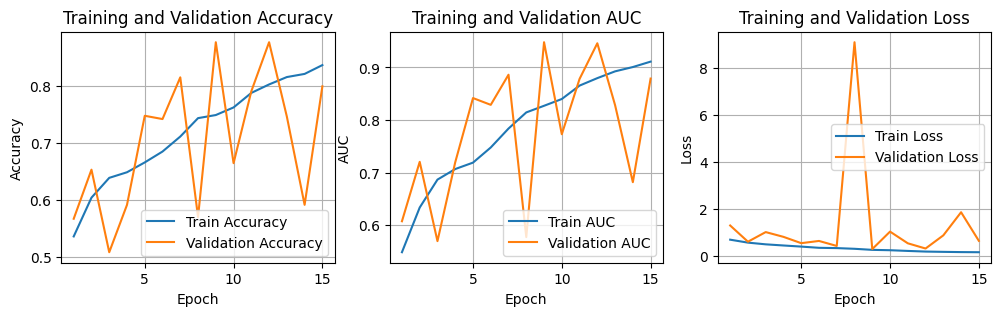

In [28]:
# Plot training and validation AUC
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1, 16),vggmodel_history_acc, label='Train Accuracy')
plt.plot(range(1, 16),vggmodel_history_acc_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(range(1, 16),vggmodel_history_auc, label='Train AUC')
plt.plot(range(1, 16),vggmodel_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 3, 3)
plt.plot(range(1, 16),vggmodel_history_loss, label='Train Loss')
plt.plot(range(1, 16),vggmodel_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

***
## Improvement with Lower Learning Rate with Lower Decay Rate
I thought the instability is derived from too high learning rate. So I tested the same model with lower learning rate and lower decay rate.

In [44]:
 # Load the VGG16
densenet_model = tf.keras.applications.VGG16(weights='imagenet',include_top = False, input_shape=(256, 256, 3))

# Freeze the weights of the layers.
for layer in densenet_model.layers[:-8]:
    layer.trainable = False

# get the last_layer of inception we want to use
last_layer = densenet_model.get_layer('block4_pool')
print('last layer output shape: ', last_layer.output_shape)

base_model = tf.keras.Model(inputs=densenet_model.input, outputs=last_layer.output)
base_model.summary()

last layer output shape:  (None, 16, 16, 512)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool 

In [45]:
# Add layers to the model
mymodel_vgg2 = tf.keras.models.Sequential([
    base_model,

    tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'), # keep the width and height
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (1, 1),activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(2, activation='softmax')
])

# Print the model summary
mymodel_vgg2.build(input_shape=(None, 256, 256, 3))
mymodel_vgg2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_3 (Functional)        (None, 16, 16, 512)       7635264   
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 16)        73744     
                                                                 
 batch_normalization_15 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                                
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 16)        272       
                                                                 
 batch_normalization_16 (Bat  (None, 16, 16, 16)       64        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 16)       

### Training and Result
Below are the graph for the new model. Same as above, I plotted accuracy, AUC and loss.

Still there are rooms for improvment, but the model is much stabler than before, and could achieve 92% of validation accuracy!

In [46]:
#Define the learning rate schedule (exponential decay)
initial_learning_rate = 0.0002
decay_steps = 1000
decay_rate = 0.8
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps, decay_rate, staircase=True)

# Compile the model
mymodel_vgg2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()]
)

In [47]:
BATCH_SIZE = 64
EPOCHS = 15

# data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,
    horizontal_flip=True,
)

# Fit vgg model
vgg_history = mymodel_vgg2.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=2
)

Epoch 1/15
99/99 - 79s - loss: 0.9132 - categorical_accuracy: 0.5917 - auc_7: 0.6218 - val_loss: 3.0613 - val_categorical_accuracy: 0.5000 - val_auc_7: 0.5650 - 79s/epoch - 793ms/step
Epoch 2/15
99/99 - 77s - loss: 0.6350 - categorical_accuracy: 0.6910 - auc_7: 0.7555 - val_loss: 0.7190 - val_categorical_accuracy: 0.5786 - val_auc_7: 0.6524 - 77s/epoch - 776ms/step
Epoch 3/15
99/99 - 77s - loss: 0.5116 - categorical_accuracy: 0.7584 - auc_7: 0.8380 - val_loss: 0.9752 - val_categorical_accuracy: 0.5557 - val_auc_7: 0.6950 - 77s/epoch - 778ms/step
Epoch 4/15
99/99 - 77s - loss: 0.4332 - categorical_accuracy: 0.8038 - auc_7: 0.8849 - val_loss: 0.6995 - val_categorical_accuracy: 0.6371 - val_auc_7: 0.7482 - 77s/epoch - 779ms/step
Epoch 5/15
99/99 - 76s - loss: 0.4445 - categorical_accuracy: 0.7994 - auc_7: 0.8798 - val_loss: 0.8809 - val_categorical_accuracy: 0.6614 - val_auc_7: 0.7663 - 76s/epoch - 770ms/step
Epoch 6/15
99/99 - 76s - loss: 0.3852 - categorical_accuracy: 0.8310 - auc_7: 0.

In [48]:
vggmodel2_history_acc=     [0.5917, 0.6910, 0.7584, 0.8038, 0.7994, 0.8310, 0.8638, 0.8956, 0.9062, 0.9254, 0.9406, 0.9562, 0.8214, 0.9654, 0.9725]
vggmodel2_history_acc_val= [0.5000, 0.5786, 0.5557, 0.6371, 0.6614, 0.8343, 0.7129, 0.7629, 0.7900, 0.6657, 0.8643, 0.8300, 0.9171, 0.7457, 0.9214]

vggmodel2_history_auc=     [0.6218, 0.7555, 0.8380, 0.8849, 0.8798, 0.9095, 0.9389, 0.9592, 0.9688, 0.9765, 0.9864, 0.9909, 0.9936, 0.9950, 0.9963]
vggmodel2_history_auc_val= [0.5650, 0.6524, 0.6950, 0.7482, 0.7663, 0.9008, 0.8054, 0.8593, 0.8865, 0.8051, 0.9504, 0.9289, 0.9721, 0.9082, 0.9785]

vggmodel2_history_loss=         [0.9132, 0.6350, 0.5116, 0.4332, 0.4445, 0.3852, 0.3167, 0.2591, 0.2275, 0.1989, 0.1579, 0.1297, 0.1116, 0.1009, 0.0873]
vggmodel2_history_loss_val=     [3.0613, 0.7190, 0.9752, 0.6995, 0.8809, 0.4043, 0.5766, 0.4899, 0.4356, 0.8558, 0.2885, 0.3583, 0.2141, 0.4814, 0.1860]

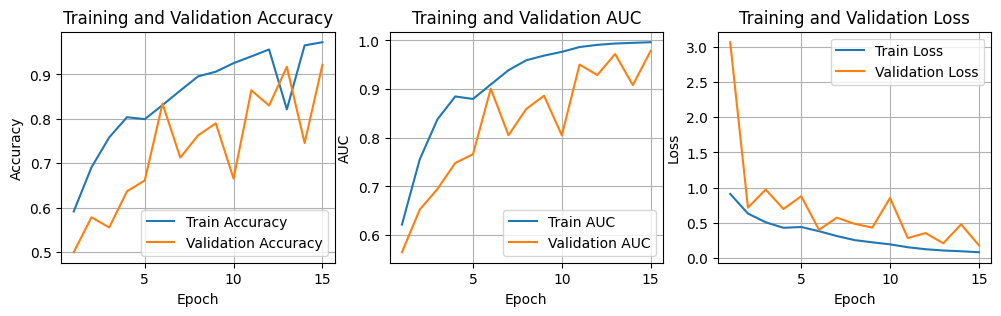

In [49]:
# Plot training and validation AUC
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.plot(range(1, 16),vggmodel2_history_acc, label='Train Accuracy')
plt.plot(range(1, 16),vggmodel2_history_acc_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(range(1, 16),vggmodel2_history_auc, label='Train AUC')
plt.plot(range(1, 16),vggmodel2_history_auc_val, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid()

# Plot training and validation loss
plt.subplot(1, 3, 3)
plt.plot(range(1, 16),vggmodel2_history_loss, label='Train Loss')
plt.plot(range(1, 16),vggmodel2_history_loss_val, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

***
## Conclusion
I could achieve better result by tweaking some hyperparemeters of the model. Maybe still there are room for improvements.

But what I'm interesting now is that how the model could differentiate with such a high accuracy. As the difference is almost impossible to tell by human eyes.  
There are several techniques known as "explainable A.I.", like GradCam to visualize which region of the image have more importance from A.I. point of view.  
This kind of technique can help us to understand how A.I. are differentiating fake with real.

We can expect that the deepfake technology itself will become more and more sophisticated so that analysis done here cannot tell the difference.  
So we may need to make breakthrough to avoid cat and mouse game.